# Machine Learning Engineer Nanodegree
## Deep Learning
## Capstone project: Rock-paper-scissors Classifier
### by Juan Andrés Ramírez

In this notebook is described the work done for the Udacity's Machine Learning Nanodegree capstone project

First make most of the imports:

In [70]:
from sklearn.datasets import load_files       

import numpy as np
from glob import glob
import os
from keras.applications.resnet50 import preprocess_input, ResNet50
import matplotlib.pyplot as plt
import cv2 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, MaxPooling2D #Conv2D, MaxPooling2D,
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.models import Sequential
from sklearn.metrics import accuracy_score, confusion_matrix
from mmtc_misc_tools import plot_confusion_matrix

from tqdm import tqdm

#### Exploring dataset
First we will start exploring the dataset and making some preprocessing. Below we load the dataset

In [2]:

#Train folder
train_folder = 'datasets/train'
validation_folder = 'datasets/validation'
test_folder = 'datasets/test'

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    img_files = np.array(data['filenames'])
    img_targets = np_utils.to_categorical(np.array(data['target']), 3)
    return img_files, img_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset(train_folder)
valid_files, valid_targets = load_dataset(validation_folder)
test_files, test_targets = load_dataset(test_folder)

# load list of classes
#class_names = [item[20:-1] for item in sorted(glob(train_folder +"/*/"))]
class_names = [name for name in os.listdir(train_folder)]

# print statistics about the dataset
print('There are %d total class categories.' % len(class_names))
#print('There are %s total class images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training images.' % len(train_files))
print('There are %d validation images.' % len(valid_files))
print('There are %d test images.'% len(test_files))
print('Classes: ')
for class_str in class_names:
    print(' - ' + class_str)

There are 3 total class categories.
There are 450 training images.
There are 90 validation images.
There are 90 test images.
Classes: 
 - paper
 - rock
 - scissors


Now we may see some of the training images:

Train images


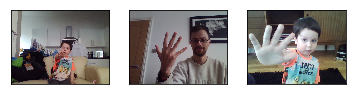

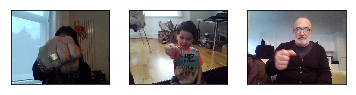

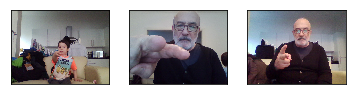

Validation images


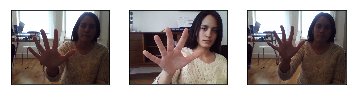

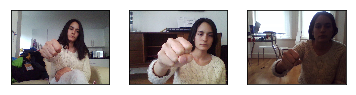

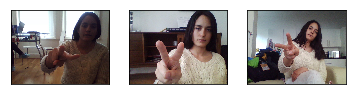

Test images


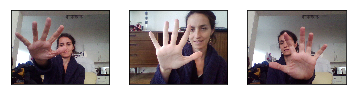

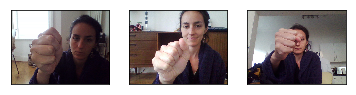

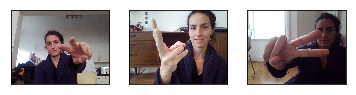

In [3]:

n_class_elements_to_show = 3

def load_image_for_show(image_path):
    img = cv2.imread(image_path)
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv_rgb

def plot_img_from_path(image_path, axes=None):
    img = load_image_for_show(image_path)
    if axes:
        axes.imshow(img)
        axes.set_xticks([])
        axes.set_yticks([])
    else:
        plt.imshow(img)

def get_int_targets(targets):
    return np.array([ np.where(r==1)[0][0] for r in targets ])

def show_images_from_set(files_list, target_int):
    for class_label in range(len(class_names)):
        class_indexes = np.nonzero(target_int==class_label)    
        f, axarr = plt.subplots(1, 3)    
        for to_show in range(n_class_elements_to_show):
            img_index = class_indexes[0][to_show]
            img_path = files_list[img_index]        
            plot_img_from_path( img_path, axarr[to_show])
    plt.show()
    
train_target_int = get_int_targets(train_targets)
valid_target_int = get_int_targets(valid_targets)
test_target_int = get_int_targets(test_targets)

print("Train images")
show_images_from_set(train_files, train_target_int)
print("Validation images")
show_images_from_set(valid_files, valid_target_int)
print("Test images")
show_images_from_set(test_files, test_target_int)

Dataset: images re-scaling and offline augmentation

In [4]:
augmentation_factor = 10
aug_dir_train = 'dataset_aug/train'
aug_dir_valid = 'dataset_aug/valid'
aug_dir_test = 'dataset_aug/test'

# Resize image
def resize_image(img_path):
    #Load image
    img = cv2.imread(img_path)
        
    #Preprocess
    img = cv2.resize(img, (224,224))

# Write augmented dataset to disk
def generate_augmented(files_list, targets_ints, aug_dir):    
    if not os.path.exists(aug_dir):
        os.makedirs(aug_dir)
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.1,
        height_shift_range=0.1,
        #shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')
    for j in range(len(files_list)):#range(1):
        img_path = files_list[j]
        img =  load_img(img_path) #resize_image(img_path)
        img = img.resize((224,224)) 
        x = img_to_array(img)  
        x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 224, 224)
        # the .flow() command below generates batches of randomly transformed images
        # and saves the results to the `preview/` directory
        out_dir = aug_dir + "/" + class_names[ targets_ints[j] ]
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
        i = 0
        for batch in datagen.flow(x, batch_size=1,seed = 9, save_to_dir=out_dir, save_prefix='aug-'+str(j).zfill(3), save_format='jpeg'):
            i += 1
            if i >= augmentation_factor:
                break  # otherwise the generator would loop indefinitely

#Uncomment the next lines to generate the augmented database
generate_augmented(train_files, train_target_int, aug_dir_train) 
print('Train ready')
generate_augmented(valid_files, valid_target_int, aug_dir_valid) 
print('Valid ready')
generate_augmented(test_files, test_target_int, aug_dir_test) 
print('Test ready')
 

Train ready
Valid ready
Test ready


Now we load the augmented database and get features using ResNet50

In [5]:
#aug dir definitions
main_aug_dir =  'dataset_aug'   
aug_dir_train = main_aug_dir + '/train'
aug_dir_valid = main_aug_dir + '/valid'
aug_dir_test = main_aug_dir + '/test'

# load augmented train, test, and validation datasets
train_files_aug, train_targets_aug = load_dataset(aug_dir_train)
valid_files_aug, valid_targets_aug = load_dataset(aug_dir_valid)
test_files_aug, test_targets_aug = load_dataset(aug_dir_test)

print('There are %d total class categories.' % len(class_names))
print('There are %d training images.' % len(train_files_aug))



There are 3 total class categories.
There are 4500 training images.


### Transfer learning approach

In [6]:
# Load ResNet50
def get_ResNet50():
    model_features_Resnet50 = ResNet50( include_top=False,
                                        weights='imagenet',
                                        input_tensor=None,
                                        input_shape=None,
                                        pooling=None)
    return model_features_Resnet50


#def path_to_tensor(img_path):
#    # loads RGB image as PIL.Image.Image type
#    img = image.load_img(img_path, target_size=(224, 224))
#    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
#    x = image.img_to_array(img)
#    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
#    return np.expand_dims(x, axis=0)

#def paths_to_tensor(img_paths):
#    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
#    return np.vstack(list_of_tensors)
   
def process_ResNet50(model_features_Resnet50, image_path):
    #Load image
    img = cv2.imread(image_path)
        
    #Preprocess      
    x = image.img_to_array(img)    
    img_tensor= np.expand_dims(x, axis=0)
    #Preprocess image for Resnet50
    img_preproccessed = preprocess_input(img_tensor)     
    
    #Obtain Resnet50 features    
    img_features = model_features_Resnet50.predict(img_preproccessed)
   
    return img_features

def get_features_from_db(path_list):
    model_features_Resnet50 = get_ResNet50()
    n_paths = len(path_list)
    features = []
    i = 0
    for image_path in path_list:
        features.append(process_ResNet50(model_features_Resnet50, image_path))
        if n_paths>100:
            if (i % (n_paths//10)) == 0:
                print ("Completed", i/n_paths*100, "[%]")
        i += 1
    features_array = np.concatenate(features, axis=0)
    return features_array

features_array_train = get_features_from_db(train_files_aug)
print('Train features ready')
features_array_valid = get_features_from_db(valid_files_aug)
print('Valid features ready')
features_array_test = get_features_from_db(test_files_aug)
print('Test features ready')

#Save Features
features_ResNet50_filename = 'features/aug_resnet50.npz'
np.savez(features_ResNet50_filename, 
         train=features_array_train, 
         valid=features_array_valid, 
         test=features_array_test, 
         train_targets=train_targets_aug, 
         valid_targets=valid_targets_aug, 
         test_targets=test_targets_aug)
         #['train', 'valid', 'test', 'train_targets', 'valid_targets', 'test_targets'])

Completed 0.0 [%]
Completed 10.0 [%]
Completed 20.0 [%]
Completed 30.0 [%]
Completed 40.0 [%]
Completed 50.0 [%]
Completed 60.0 [%]
Completed 70.0 [%]
Completed 80.0 [%]
Completed 90.0 [%]
Train features ready
Completed 0.0 [%]
Completed 10.0 [%]
Completed 20.0 [%]
Completed 30.0 [%]
Completed 40.0 [%]
Completed 50.0 [%]
Completed 60.0 [%]
Completed 70.0 [%]
Completed 80.0 [%]
Completed 90.0 [%]
Valid features ready
Completed 0.0 [%]
Completed 10.0 [%]
Completed 20.0 [%]
Completed 30.0 [%]
Completed 40.0 [%]
Completed 50.0 [%]
Completed 60.0 [%]
Completed 70.0 [%]
Completed 80.0 [%]
Completed 90.0 [%]
Test features ready


Load features

In [6]:
features_ResNet50_filename = 'features/aug_resnet50.npz'
all_features = np.load(features_ResNet50_filename)
features_array_train = all_features['train']
features_array_valid = all_features['valid']
features_array_test = all_features['test']
train_targets_aug = all_features['train_targets']
valid_targets_aug = all_features['valid_targets']
test_targets_aug = all_features['test_targets']

Here we define the model

In [79]:
#Defining architecture.
model_1 = Sequential()
print(features_array_train.shape[1:])
model_1.add(GlobalAveragePooling2D(input_shape=features_array_train.shape[1:]) )
model_1.add(MaxPooling2D(pool_size=(2,2) ) )
model_1.add(Dense(3, activation='softmax') )
model_1.summary()

(1, 1, 2048)


ValueError: Input 0 is incompatible with layer max_pooling2d_6: expected ndim=4, found ndim=2

In [55]:
model_1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [56]:
def plot_training_history(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Training the model

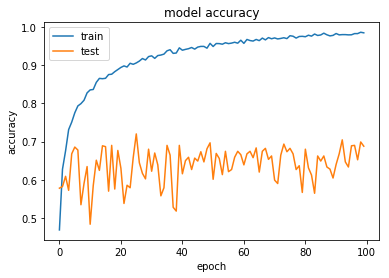

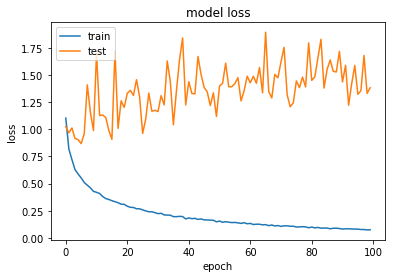

In [57]:
#Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.model_1.hdf5', 
                               verbose=0, save_best_only=True)

history = model_1.fit(features_array_train, 
            train_targets_aug, 
            #validation_split=0.2,
            validation_data=(features_array_valid, valid_targets_aug),
            epochs=100, batch_size=90, callbacks=[checkpointer], verbose=0,
            shuffle=True)
plot_training_history(history)

Now, we check classification over some training samples

testing_accuracy_score 0.614444444444


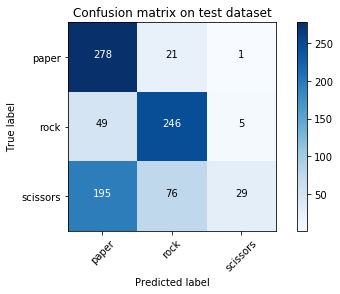

In [25]:
model_1.load_weights('saved_models/weights.best.model_1.hdf5')

def classify_features(features):
    #Calc predictions
    rps_predictions = [np.argmax(model_1.predict(np.expand_dims(tensor, axis=0))) for tensor in features]
    rps_predictions_string = [class_names[class_index] for class_index in rps_predictions]
    return rps_predictions, rps_predictions_string

def classify_images(img_paths):
    paths_features = get_features_from_db(img_paths)
    return classify_features(paths_features)



#Calculate accuracy score on testing set
test_predictions, test_predictions_string = classify_features(features_array_test)
test_targets_aug_int = get_int_targets(test_targets_aug)
testing_accuracy_score = accuracy_score(test_targets_aug_int, test_predictions)
testing_cm = confusion_matrix(test_targets_aug_int, test_predictions)
print ('testing_accuracy_score', testing_accuracy_score)
plt.figure()
plot_confusion_matrix(testing_cm, classes=class_names,
                      title='Confusion matrix on test dataset')
plt.show()
#print('testing_confusion_matrix', testing_cm)


Image: dataset_aug/test/rock/aug-067_0_3725.jpeg , prediction: paper


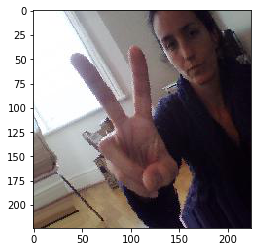

Image: dataset_aug/test/paper/aug-049_0_3725.jpeg , prediction: paper


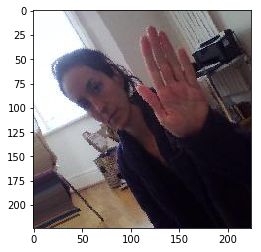

Image: dataset_aug/test/scissors/aug-051_0_6782.jpeg , prediction: rock


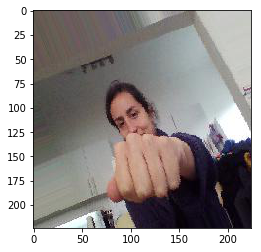

Image: dataset_aug/test/rock/aug-086_0_6782.jpeg , prediction: scissors


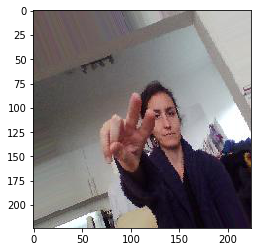

Image: dataset_aug/test/paper/aug-044_0_9105.jpeg , prediction: paper


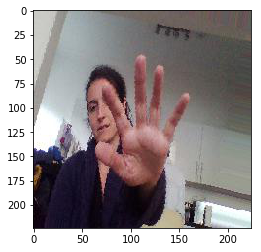

Image: dataset_aug/test/scissors/aug-074_0_7056.jpeg , prediction: rock


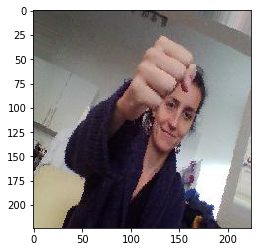

Image: dataset_aug/test/rock/aug-036_0_6782.jpeg , prediction: scissors


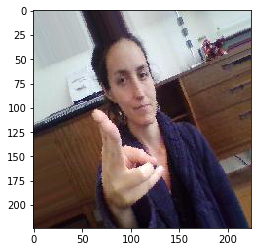

Image: dataset_aug/test/scissors/aug-038_0_9105.jpeg , prediction: rock


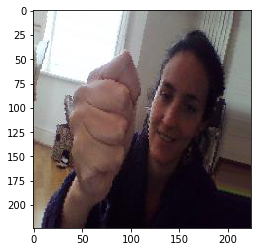

Image: dataset_aug/test/scissors/aug-017_0_6782.jpeg , prediction: rock


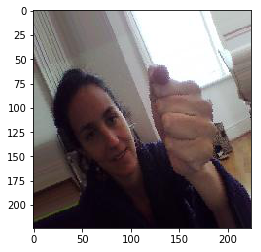

In [36]:
def show_prediction (img_path, pred_str):
    print('Image:', img_path, ', prediction:', pred_str)
    plot_img_from_path(img_path)
    plt.show()
    
def show_predictions(showing_paths, features):
    pred, pred_str = classify_features(features)
    for i in range(len(showing_paths)):
        show_prediction (showing_paths[i], pred_str[i])
    return pred, pred_str
def show_random_pred_samples(showing_paths, features):
    indexes = np.random.permutation(len(showing_paths))
    indexes = indexes[0:9]
    show_predictions(showing_paths[indexes], features[indexes])
    
show_random_pred_samples(test_files_aug, features_array_test)